<a href="https://colab.research.google.com/github/AbelKosh/NeurIPS/blob/main/First_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First Submission

## 1D CNN

In [ ]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanAbsoluteError

In [ ]:
# Setup paths
folder = '/content/drive/MyDrive/NeurIPS/Data'


# Read data
data_train = np.load(f'{folder}/data_train.npy')
FGS_train = np.load(f'{folder}/data_train_FGS.npy')


# Create a directory to save outputs and define the hyperparameters
output_dir = './output'

SEED = 42

do_the_mcdropout_wc = True
do_the_mcdropout = True

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory {output_dir} created.")
else:
    print(f"Directory {output_dir} already exists.")

Directory ./output created.


In [ ]:
# Preprocessing for 1D CNN

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

train_solution = np.loadtxt(f'{folder}/train_labels.csv', delimiter = ',', skiprows= 1)

targets = train_solution[:,1:]
targets_mean = targets[:,1:].mean(axis = 1) # used for the 1D-CNN to extract the mean value, only AIRS data used in the white curve

N = targets.shape[0]

In [ ]:
planet_ids = train_solution[:,0]
print(planet_ids.shape)

(673,)


In [ ]:
print(targets.shape)

(673, 283)


In [ ]:
# Create the dataset by adding the FGS frame, crushed in one column, at the end of the AIRS data cube.
# The images are normailzed using the star spectrum extracted from the images themselves.
AIRS_signal, FGS_signal = data_train, FGS_train
FGS_column = FGS_signal.sum(axis = 2)

dataset = np.concatenate([AIRS_signal, FGS_column[:,:, np.newaxis,:]], axis = 2)

In [ ]:
# Sum up the pixels on the y_axis to transform the data into 2D images
dataset = dataset.sum(axis=3)

# Divide the images by the star flux assuming the first and last 50 instants belong to the out of trainsit
def norm_star_spectrum (signal) :
    img_star = signal[:,:50].mean(axis = 1) + signal[:,-50:].mean(axis = 1)
    return signal/img_star[:,np.newaxis,:]

dataset_norm = norm_star_spectrum(dataset)
dataset_norm = np.transpose(dataset_norm,(0,2,1))

In [ ]:
# Compute a "white curve", that is the sum of the signal over the entire image as a funtion of time
# Split the data and normalize the train/valid/test data.
cut_inf, cut_sup = 39, 321 # we previously cut along the wavelengths to remove the edges, this is to match with the targets range
l = cut_sup - cut_inf + 1
wls = np.arange(l)


def split(data, N_train):
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    train_indices = indices[:N_train]
    valid_indices = indices[N_train:]
    data_1 = data[train_indices]
    data_2 = data[valid_indices]
    list_index_1 = np.zeros(data.shape[0], dtype=bool)
    list_index_1[train_indices] = True
    return data_1, data_2, list_index_1

N_train = 8*N//10

In [ ]:
# Validation and train data split
train_obs, valid_obs, list_index_train = split(dataset_norm, N_train)
train_targets, valid_targets = targets[list_index_train], targets[~list_index_train]
valid_planets_ids = planet_ids[~list_index_train]


# Define variables
AIRS_signal = AIRS_signal.sum(axis=3)
wc_mean = AIRS_signal.mean(axis=1).mean(axis=1)
white_curve = AIRS_signal.sum(axis=2)/ wc_mean[:, np.newaxis]

In [ ]:
print(valid_planets_ids.shape)

(135,)


In [ ]:
def normalise_wlc(train, valid) :

    wlc_train_min = train.min()
    wlc_train_max = train.max()
    train_norm = (train - wlc_train_min) / (wlc_train_max - wlc_train_min)
    valid_norm = (valid - wlc_train_min) / (wlc_train_max - wlc_train_min)

    return train_norm, valid_norm

#Incase divion by zero is occuring
def normalize(train, valid):
    epsilon = 1e-8
    max_train = train.max()
    min_train = train.min()
    denom = max_train - min_train + epsilon
    train_norm = (train - min_train) / denom
    valid_norm = (valid - min_train) / denom
    return train_norm, valid_norm, min_train, max_train

In [ ]:
# Split the light curves and targets
train_wc, valid_wc = white_curve[list_index_train], white_curve[~list_index_train]
train_targets_wc, valid_targets_wc = targets_mean[list_index_train], targets_mean[~list_index_train]

# Normalize the wlc
train_wc, valid_wc = normalise_wlc(train_wc, valid_wc)

# Normalize the targets
train_targets_wc_norm, valid_targets_wc_norm, min_train_valid_wc, max_train_valid_wc = normalize(train_targets_wc, valid_targets_wc)

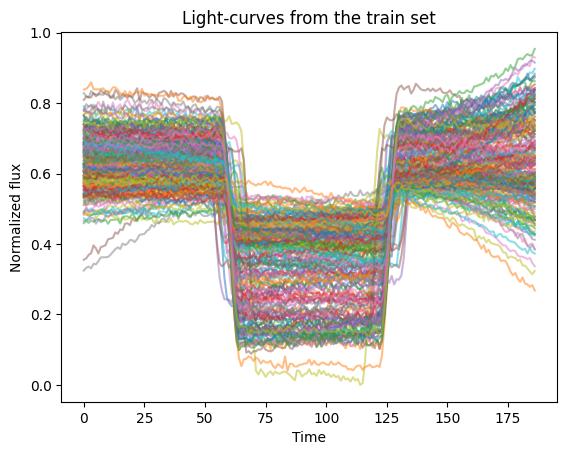

In [ ]:
# Plot ligth-curves from train set
plt.figure()
for i in range (200) :
    plt.plot(train_wc[-i], '-', alpha = 0.5)
plt.title('Light-curves from the train set')
plt.xlabel('Time')
plt.ylabel('Normalized flux')
plt.show()

In [ ]:
# This model estimates the mean of the target spectrum using the white light_curve. 1d CNN with Dropout layers to make a MC Dropout prediction.

from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Concatenate,AveragePooling1D
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint


input_wc = Input((187,1))
x = Conv1D(32, 3, activation='relu')(input_wc)
x = MaxPooling1D()(x)
x = BatchNormalization() (x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(256, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Flatten()(x)

x = Dense(500, activation='relu')(x)
x = Dropout(0.2)(x, training = True)
x = Dense(100, activation='relu')(x)
x = Dropout(0.1)(x, training = True)
output_wc = Dense(1, activation='linear')(x)

model_wc = Model(inputs=input_wc, outputs=output_wc)
model_wc.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 187, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 185, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 92, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 92, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 90, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 43, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 19, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 9, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │       1,152,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          50,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,332,429 (5.08 MB)

 Trainable params: 1,332,365 (5.08 MB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
def scheduler(epoch, lr):
    decay_rate = 0.2
    decay_step = 200
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

optimizer = SGD(0.001)
model_wc.compile(optimizer=optimizer, loss='mse', metrics=[MeanAbsoluteError()])
callback = LearningRateScheduler(scheduler)
checkpoint_filepath = 'output/model_1dcnn.keras'
model_ckt = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)

print('Running ...')
history = model_wc.fit(
    x = train_wc,
    y = train_targets_wc_norm,
    validation_data = (valid_wc, valid_targets_wc_norm),
    batch_size=16,
    epochs= 1200,
    shuffle=True,
    verbose=0,
    callbacks=[model_ckt]
    )
print('Done.')

Running ...
Done.


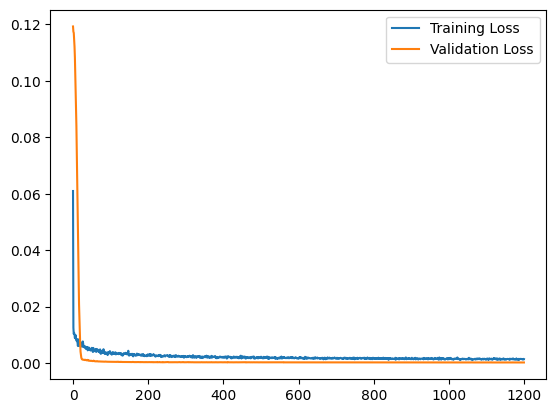

In [ ]:
model_wc = load_model(checkpoint_filepath)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
nb_dropout_wc = 1000

def unstandardizing (data, min_train_valid, max_train_valid) :
    return data * (max_train_valid - min_train_valid) + min_train_valid

def MC_dropout_WC (model, data, nb_dropout) :
    predictions = np.zeros((nb_dropout, data.shape[0]))
    for i in range(nb_dropout) :
        predictions[i,:] = model.predict(data, verbose = 0).flatten()
    return predictions

if do_the_mcdropout_wc :
    print('Running ...')
    prediction_valid_wc = MC_dropout_WC(model_wc, valid_wc, nb_dropout_wc)
    spectre_valid_wc_all = unstandardizing(prediction_valid_wc, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_wc, spectre_valid_std_wc = spectre_valid_wc_all.mean(axis = 0), spectre_valid_wc_all.std(axis = 0)
    print('Done.')

else :
    spectre_valid_wc = model_wc.predict(valid_wc).flatten( )
    spectre_valid_wc = unstandardizing(spectre_valid_wc, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_std_wc = 0.1*np.abs(spectre_valid_wc)

Running ...
Done.


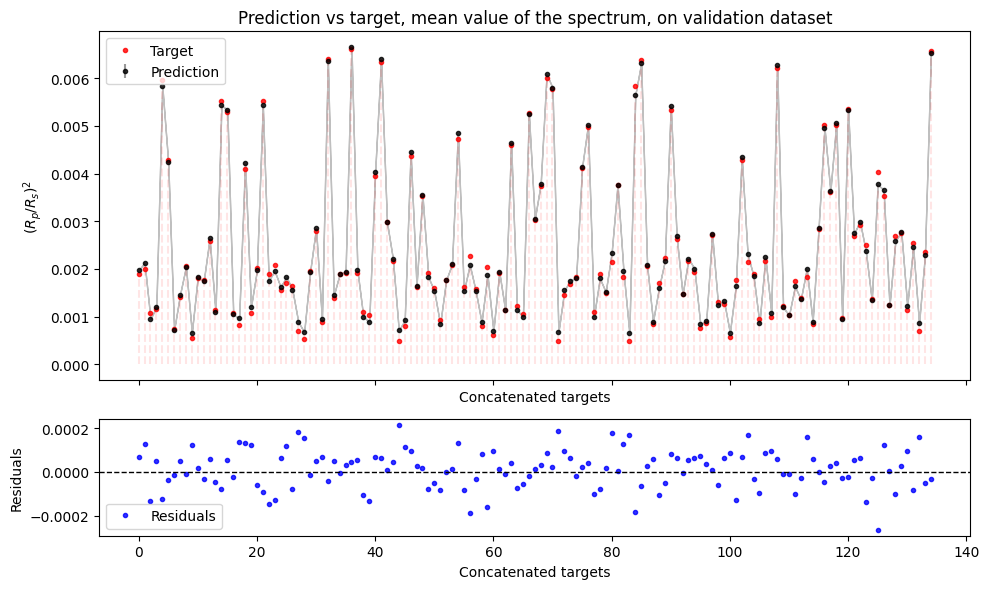

In [ ]:
residuals = spectre_valid_wc - valid_targets_wc
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

ax1.errorbar(x = np.arange(len(spectre_valid_wc)), y = spectre_valid_wc, yerr =spectre_valid_std_wc, fmt = '.', color = 'k', ecolor = 'gray', label='Prediction', alpha=0.8)
ax1.fill_between(np.arange(len(spectre_valid_wc)), spectre_valid_wc - spectre_valid_std_wc, spectre_valid_wc + spectre_valid_std_wc, color = 'grey', alpha = 0.5)
ax1.vlines(np.arange(len(spectre_valid_wc)),ymin=0, ymax=spectre_valid_wc, colors='r', linestyle='dashed',alpha = 0.1)
ax1.plot(valid_targets_wc, 'r.', label='Target', alpha=0.8)
ax1.set_xlabel('Concatenated targets')
ax1.set_ylabel('$(R_p/R_s)^2$')
ax1.set_title('Prediction vs target, mean value of the spectrum, on validation dataset')
ax1.legend()

ax2.plot(residuals, 'b.', label='Residuals', alpha=0.8)
ax2.set_xlabel('Concatenated targets')
ax2.set_ylabel('Residuals')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
residuals = valid_targets_wc - spectre_valid_wc
print('MSE : ', np.sqrt((residuals**2).mean())*1e6, 'ppm')

MSE :  89.33558340612178 ppm


In [ ]:
# Save results to output directory

np.save(f'{output_dir}/pred_valid_wc.npy', spectre_valid_wc)
np.save(f'{output_dir}/targ_valid_wc.npy', valid_targets_wc)
np.save(f'{output_dir}/std_valid_wc.npy', spectre_valid_std_wc)

### 2D CNN for atmospheric features
Remove the mean value (transit depth) of the spectra to keep atmospheric features only

In [ ]:
# Preprocessing for 2D CNN

train_solution_2 = np.loadtxt(f'{folder}/train_labels.csv', delimiter = ',', skiprows= 1)

targets_2 = train_solution[:,1:]
targets_mean_2 = targets[:,1:].mean(axis = 1) # used for the 1D-CNN to extract the mean value, only AIRS wavelengths as the FGS point is not used in the white curve

N_2 = targets.shape[0]

# Create the dataset by adding the FGS frame, crushed in one column, at the end of the AIRS data cube. The images are normailzed using the star spectrum extracted from the images themselves.

AIRS_signal_2, FGS_signal_2 = data_train, FGS_train
FGS_column_2 = FGS_signal_2.sum(axis = 2)

dataset_2 = np.concatenate([AIRS_signal_2, FGS_column_2[:,:, np.newaxis,:]], axis = 2)

# Sum up the pixels on the y_axis to transform the data into 2D images
dataset_2 = dataset_2.sum(axis=3)

# Divide the images by the star flux assuming the first and last 50 instants belong to the out of trainsit

def create_dataset_norm(dataset1, dataset2) :
    dataset_norm1 = np.zeros(dataset1.shape)
    dataset_norm2 = np.zeros(dataset1.shape)
    dataset_min = dataset1.min()
    dataset_max = dataset1.max()
    dataset_norm1 = (dataset1 - dataset_min) / (dataset_max - dataset_min)
    dataset_norm2 = (dataset2 - dataset_min) / (dataset_max - dataset_min)
    return dataset_norm1, dataset_norm2


def norm_star_spectrum (signal) :
    img_star = signal[:,:50].mean(axis = 1) + signal[:,-50:].mean(axis = 1)
    return signal/img_star[:,np.newaxis,:]

dataset_norm_2 = norm_star_spectrum(dataset_2)
dataset_norm_2 = np.transpose(dataset_norm_2,(0,2,1))

# Split the data and normalize the train/valid/test data.

cut_inf, cut_sup = 39, 321 # we previously cut the data along the wavelengths to remove the edges, this is to match with the targets range in the make data file
l = cut_sup - cut_inf + 1
wls = np.arange(l)


def split (data, N) :
    list_planets = random.sample(range(0, data.shape[0]), N_train)
    list_index_1 = np.zeros(data.shape[0], dtype = bool)
    for planet in list_planets :
        list_index_1[planet] = True
    data_1 = data[list_index_1]
    data_2 = data[~list_index_1]
    return data_1, data_2, list_index_1

N_train = 8*N//10

# Validation and train data split
train_obs_2, valid_obs_2, list_index_train_2 = split(dataset_norm_2, N_train)
train_targets_2, valid_targets_2 = targets_2[list_index_train], targets_2[~list_index_train]

In [ ]:
# Preprocessing for 2D CNN

def suppress_mean(targets, mean) :
    res = targets - np.repeat(mean.reshape((mean.shape[0], 1)), repeats = targets.shape[1], axis = 1)
    return res
train_targets, valid_targets = targets[list_index_train], targets[~list_index_train]

train_targets_shift = suppress_mean(train_targets_2,  targets_mean_2[list_index_train])
valid_targets_shift = suppress_mean(valid_targets_2,  targets_mean_2[~list_index_train])

In [ ]:
# Normalize the targets so that they range between -1 and 1, centered on 0

def targets_normalization (data1, data2) :
    data_min = data1.min()
    data_max = data1.max()
    data_abs_max = np.max([data_min, data_max])
    data1 = data1/data_abs_max
    data2 = data2/data_abs_max
    return data1, data2, data_abs_max

def targets_norm_back (data, data_abs_max) :
    return data * data_abs_max

train_targets_norm, valid_targets_norm, targets_abs_max = targets_normalization(train_targets_shift, valid_targets_shift)

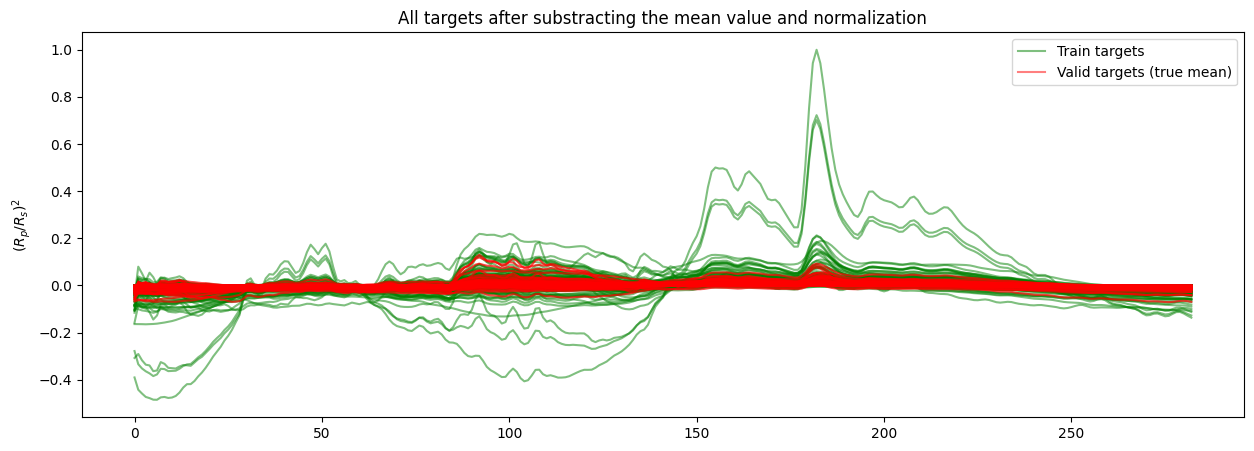

In [ ]:
plt.figure(figsize=(15,5))

for i in range (240) :
    plt.plot(wls, train_targets_norm[i], 'g-', alpha = 0.5)
plt.plot([], [], 'g-', alpha=0.5, label='Train targets')
for i in range (60) :
    plt.plot(wls, valid_targets_norm[i], 'r-', alpha = 0.7)
plt.plot([], [], 'r-', alpha=0.5, label='Valid targets (true mean)')

plt.legend()
plt.ylabel(f'$(R_p/R_s)^2$')
plt.title('All targets after substracting the mean value and normalization')
plt.show()

In [ ]:
# Transpose
train_obs = train_obs_2.transpose(0, 2, 1)
valid_obs = valid_obs_2.transpose(0, 2, 1)
print(train_obs.shape)

(538, 187, 283)


In [ ]:
# Cut the transit to keep only in-transit, assume an arbitrary transit duration of 40 instants with a transit occuring between 75 and 115.

def suppress_out_transit (data, ingress, egress) :
    data_in = data[:, ingress:egress,:]
    return data_in

ingress, egress = 75,115
train_obs_in = suppress_out_transit(train_obs, ingress, egress)
valid_obs_in = suppress_out_transit(valid_obs, ingress, egress)

In [ ]:
# Substract the mean value of the in-transit to get relative data like the targets

def substract_data_mean(data):
    data_mean = np.zeros(data.shape)
    for i in range(data.shape[0]):
        data_mean[i] = data[i] - data[i].mean()
    return data_mean

train_obs_2d_mean = substract_data_mean(train_obs_in)
valid_obs_2d_mean = substract_data_mean(valid_obs_in)

In [ ]:
# Use the same normalization as for the targets, between -1 and 1 centered on zero

def data_norm(data1, data2):
    data_min = data1.min()
    data_max = data1.max()
    data_abs_max = np.max([data_min, data_max])
    data1 = data1/data_abs_max
    data2 = data2/data_abs_max
    return data1, data2, data_abs_max


def data_normback(data, data_abs_max) :
    return data * data_abs_max

train_obs_norm, valid_obs_norm, data_abs_max = data_norm(train_obs_2d_mean, valid_obs_2d_mean)

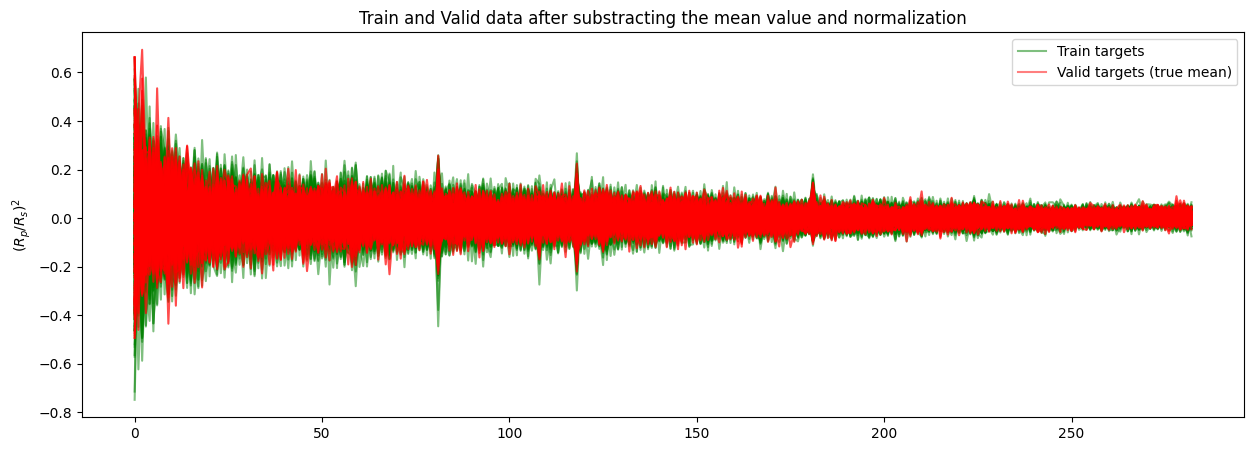

In [ ]:
plt.figure(figsize=(15,5))
for i in range (train_obs.shape[0]) :
    plt.plot(wls, train_obs_norm[i,10], 'g-', alpha = 0.5)
plt.plot([], [], 'g-', alpha=0.5, label='Train targets')
for i in range (valid_obs.shape[0]) :
    plt.plot(wls, valid_obs_norm[i,10], 'r-', alpha = 0.7)
plt.plot([], [], 'r-', alpha=0.5, label='Valid targets (true mean)')

plt.legend()
plt.ylabel(f'$(R_p/R_s)^2$')
plt.title('Train and Valid data after substracting the mean value and normalization')
plt.show()

In [ ]:
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Reshape, Dropout, BatchNormalization, AveragePooling2D
from keras.models import Model
import tensorflow as tf
import numpy as np

## CNN 2 global normalization data
input_obs = Input((40,283,1))
x = Conv2D(32, (3, 1), activation='relu', padding='same')(input_obs)
x = MaxPooling2D((2, 1))(x)
x = BatchNormalization() (x)
x = Conv2D(64, (3, 1), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 1))(x)
x = Conv2D(128, (3, 1), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 1))(x)
x = Conv2D(256, (3, 1), activation='relu', padding='same')(x)
x = Conv2D(32, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = BatchNormalization() (x)
x = Conv2D(64, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = Conv2D(128, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = Conv2D(256, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = Flatten()(x)
# DNN
x = Dense(700, activation='relu')(x)
x = Dropout(0.2)(x, training = True)
output = Dense(283, activation='linear')(x)

model = Model(inputs=[input_obs], outputs=output)

checkpoint_filepath = 'output/model_2dcnn.keras'
model_ckt2 = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)
model.compile(optimizer=Adam(0.001), loss='mse', metrics=[MeanAbsoluteError()])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 40, 283, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 40, 283, 32)         │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 20, 283, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 283, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 20, 283, 64)         │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 283, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 283, 128)        │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 283, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 5, 283, 256)         │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 283, 32)          │          24,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 141, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 5, 141, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 141, 64)          │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 70, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 5, 70, 128)          │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 35, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 5, 35, 256)          │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 5, 17, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 21760)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 700)                 │      15,232,700 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,715,019 (59.95 MB)

 Trainable params: 15,714,891 (59.95 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
history = model.fit(
     x = train_obs_norm,
     y = train_targets_norm,
     validation_data = (valid_obs_norm, valid_targets_norm),
     batch_size=32,
     epochs= 200,
     shuffle=True,
     verbose=0,
    callbacks=[model_ckt2]
 )

## PostProcessing and Visualization

In [ ]:
# Obtain uncertainties on the predictions by computing a MCDropout

nb_dropout = 5

def NN_uncertainity(model, x_test, targets_abs_max, T=5):
    predictions = []
    for _ in range(T):
        pred_norm = model.predict([x_test],verbose=0)
        pred = targets_norm_back(pred_norm, targets_abs_max)
        predictions += [pred]
    mean, std = np.mean(np.array(predictions), axis=0), np.std(np.array(predictions), axis=0)
    return mean, std


if do_the_mcdropout :
    spectre_valid_shift, spectre_valid_shift_std = NN_uncertainity(model, [valid_obs_norm], targets_abs_max, T = nb_dropout)

else :

    pred_valid_norm = model.predict([valid_obs_norm])
    pred_valid = targets_norm_back(pred_valid_norm, targets_abs_max)
    spectre_valid_shift = pred_valid
    spectre_valid_shift_std = spectre_valid_shift*0.1

In [ ]:
residuals = valid_targets_shift - spectre_valid_shift
print('MSE : ', np.sqrt((residuals**2).mean())*1e6, 'ppm')

MSE :  60.80185633996087 ppm


In [ ]:
# Save results to output directory

np.save(f'{output_dir}/pred_valid_shift.npy', spectre_valid_shift)
np.save(f'{output_dir}/targ_valid_shift.npy', valid_targets_shift)
np.save(f'{output_dir}/std_valid_shift.npy', spectre_valid_shift_std)

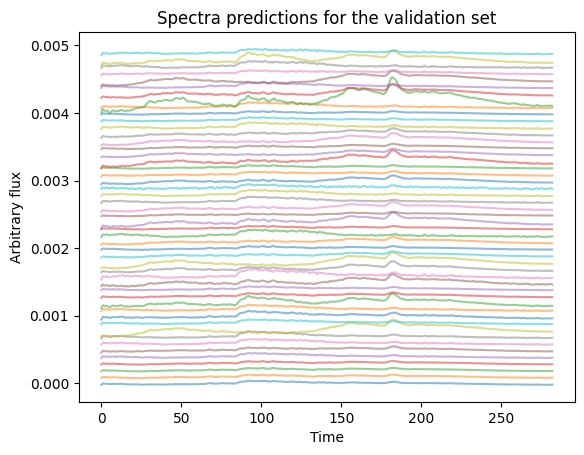

In [ ]:
plt.figure()
for i in range (50) :
    plt.plot(spectre_valid_shift[-i]+0.0001*i, '-', alpha = 0.5)
plt.title('Spectra predictions for the validation set')
plt.xlabel('Time')
plt.ylabel('Arbitrary flux')
plt.show()

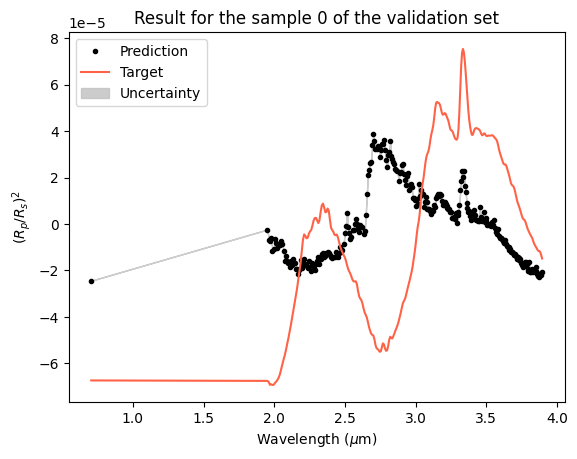

<Figure size 640x480 with 0 Axes>

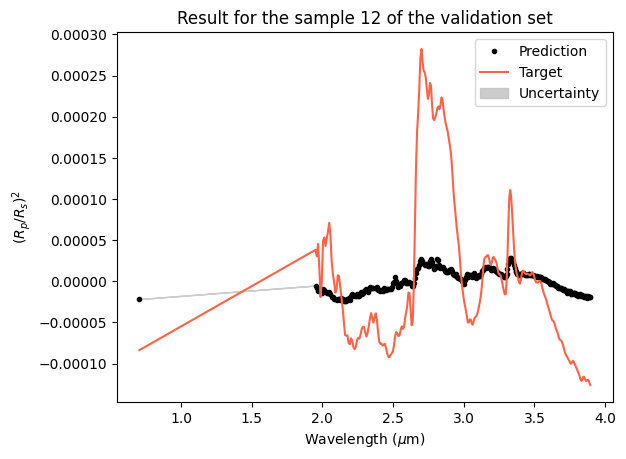

<Figure size 640x480 with 0 Axes>

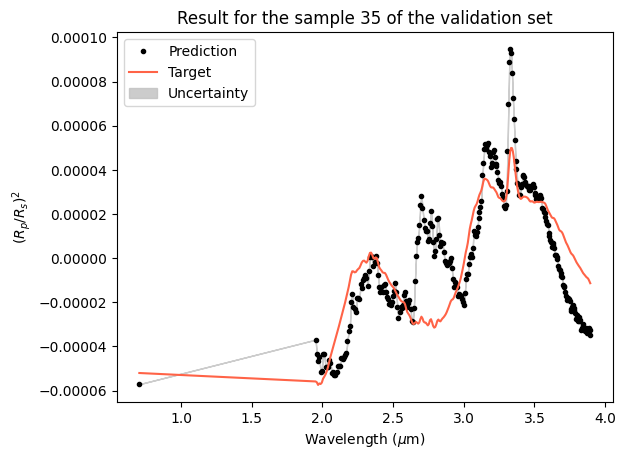

<Figure size 640x480 with 0 Axes>

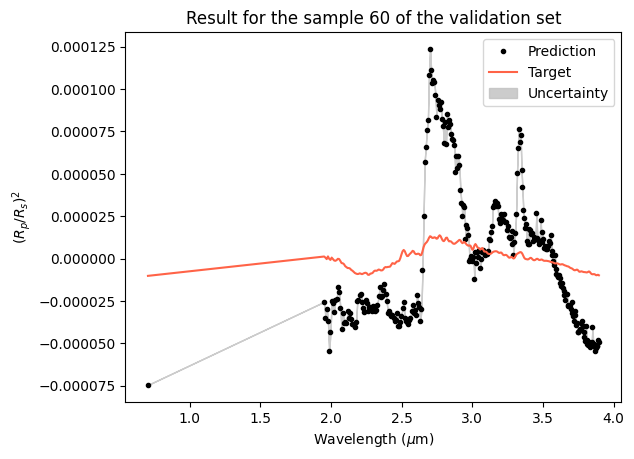

<Figure size 640x480 with 0 Axes>

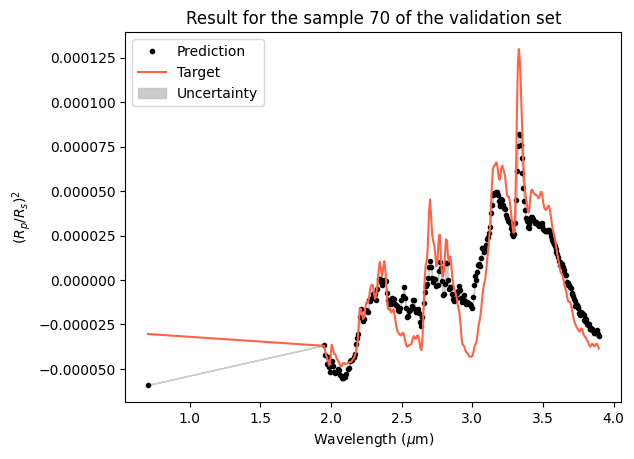

<Figure size 640x480 with 0 Axes>

In [ ]:
list_valid_planets = [0, 12, 35, 60, 70]
wavelength = np.loadtxt('/content/drive/MyDrive/NeurIPS/Auxiliary/wavelengths.csv', skiprows=1, delimiter = ',')
uncertainty = spectre_valid_shift_std
for i in (list_valid_planets):
    plt.figure()
    plt.title('Result for the sample {} of the validation set'.format(i))
    plt.plot(wavelength, spectre_valid_shift[i], '.k', label = 'Prediction')
    plt.plot(wavelength, valid_targets_shift[i], color = 'tomato', label = 'Target')
    plt.fill_between(wavelength, spectre_valid_shift[i] - spectre_valid_shift_std[i], spectre_valid_shift[i] + spectre_valid_shift_std[i], color='silver', alpha = 0.8, label = 'Uncertainty')
    plt.legend()
    plt.ylabel(f'$(R_p/R_s)^2$')
    plt.xlabel(f'Wavelength ($\mu$m)')
    plt.show()
    plt.tight_layout()

### Combine 1D and 2D CNN output for Final Spectra

In [ ]:
# Add the fluctuation to the mean

def add_the_mean (shift, mean) :
    return shift + mean[:,np.newaxis]

predictions_valid = add_the_mean(spectre_valid_shift,spectre_valid_wc)

predictions_std_valid = np.sqrt(spectre_valid_std_wc[:,np.newaxis]**2 + spectre_valid_shift_std**2)

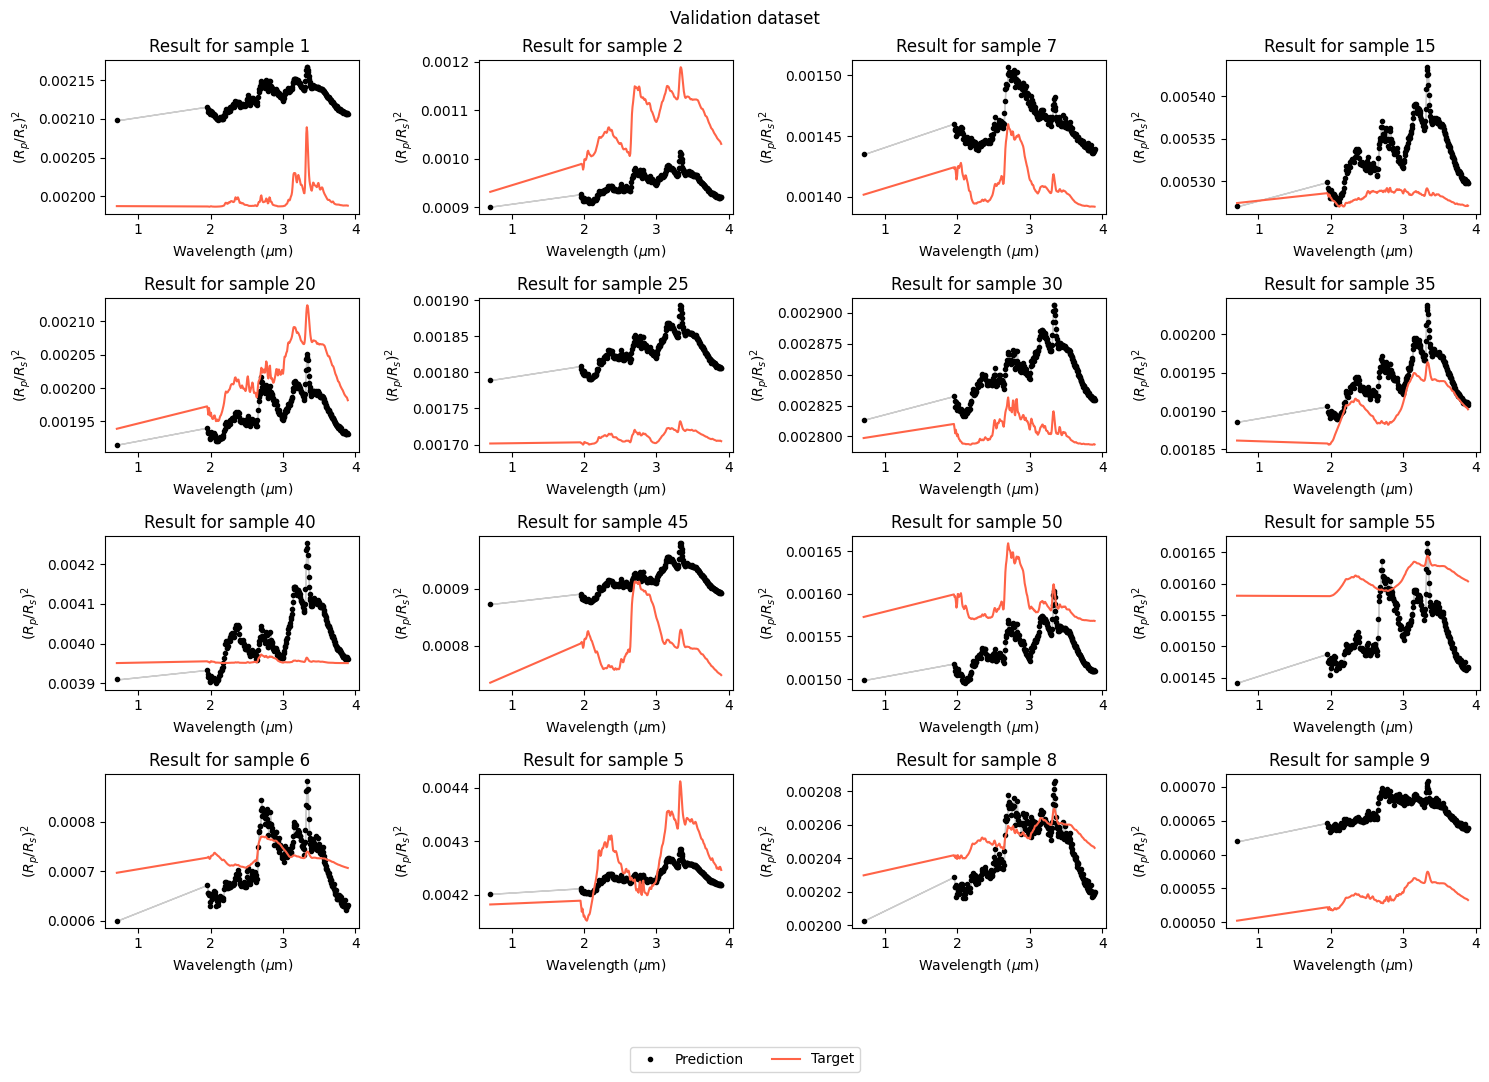

In [ ]:
uncertainty = predictions_std_valid

def plot_one_sample_valid(ax, p):
    ax.set_title(f'Result for sample {p} ')
    line1, = ax.plot(wavelength, predictions_valid[p], '.k', label='Prediction')
    line2, = ax.plot(wavelength, valid_targets[p], color='tomato', label='Target')
    ax.fill_between(wavelength, predictions_valid[p, :] - uncertainty[p], predictions_valid[p, :] + uncertainty[p], color='silver', alpha=0.8, label='Uncertainty')
    ax.set_ylabel(f'$(R_p/R_s)^2$')
    ax.set_xlabel(f'Wavelength ($\mu$m)')
    return line1, line2


num_samples = 16
rows, cols = 4, 4

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
samples = [1, 2, 7, 15, 20, 25, 30, 35, 40, 45, 50, 55, 6, 5, 8, 9]
lines = []

for i, ax in enumerate(axs.flat):
    lines.extend(plot_one_sample_valid(ax, samples[i]))

fig.legend(lines[:2], ['Prediction', 'Target'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05))
fig.suptitle('Validation dataset')
plt.tight_layout()
plt.show()

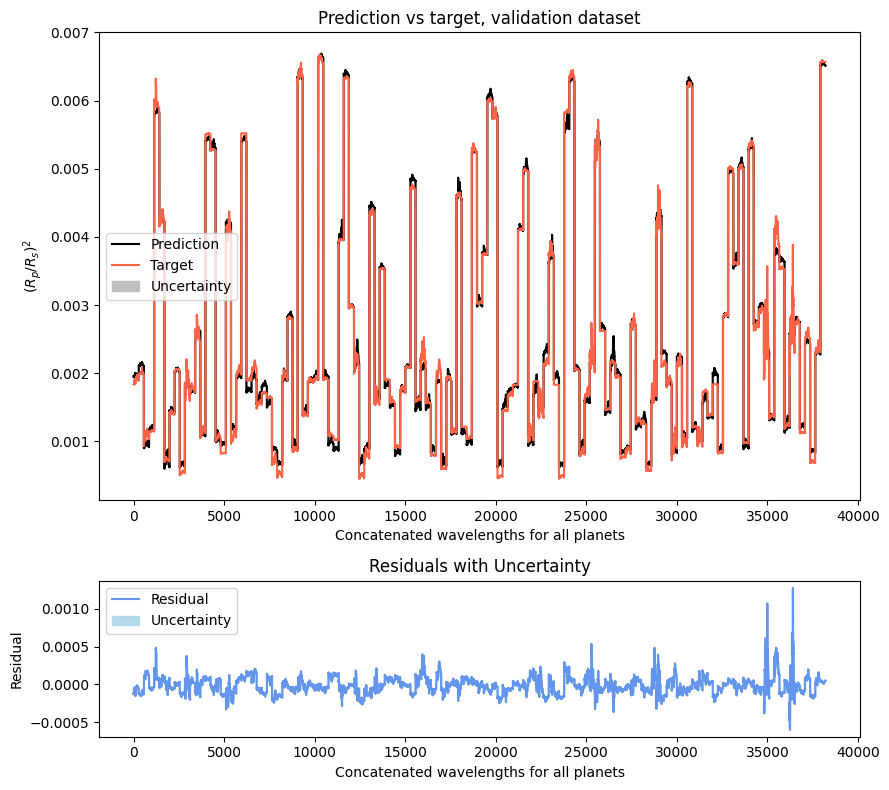

MSE :  107.98481288673571 ppm


In [ ]:
# Plot the result

predictions = predictions_valid
targets_plot = valid_targets
std = predictions_std_valid

predictions_concatenated_plot = np.concatenate(predictions, axis=0)
wls_concatenated = np.arange(predictions_concatenated_plot.shape[0])
targets_concatenated_plot = np.concatenate(targets_plot, axis=0)
spectre_valid_std_concatenated = np.concatenate(std, axis=0)
residuals = targets_concatenated_plot - predictions_concatenated_plot
uncertainty = spectre_valid_std_concatenated

fig, axs = plt.subplots(2, 1, figsize=(9, 8), gridspec_kw={'height_ratios': [3, 1]})


axs[0].plot(wls_concatenated, predictions_concatenated_plot, '-', color='k', label="Prediction")
axs[0].plot(wls_concatenated, targets_concatenated_plot, '-', color='tomato', label="Target")
axs[0].fill_between(np.arange(len(wls_concatenated)),
                    predictions_concatenated_plot - uncertainty,
                    predictions_concatenated_plot + uncertainty,
                    color='silver', alpha=1, label='Uncertainty')
axs[0].set_xlabel('Concatenated wavelengths for all planets')
axs[0].set_ylabel(f'$(R_p/R_s)^2$')
axs[0].set_title('Prediction vs target, validation dataset')
axs[0].legend()

axs[1].plot(wls_concatenated, residuals, '-', color='cornflowerblue', label="Residual")
axs[1].fill_between(np.arange(len(wls_concatenated)),
                    residuals - uncertainty,
                    residuals + uncertainty,
                    color='lightblue', alpha=0.9, label='Uncertainty')
axs[1].set_xlabel('Concatenated wavelengths for all planets')
axs[1].set_ylabel('Residual')
axs[1].set_title('Residuals with Uncertainty')
axs[1].legend()

plt.tight_layout()
plt.show()

print('MSE : ',np.sqrt((residuals**2).mean())*1e6, 'ppm')

In [ ]:
# Save results to ouptput directory

np.save(f'{output_dir}/pred_valid.npy', predictions_valid)
np.save(f'{output_dir}/std_valid.npy', predictions_std_valid)

In [ ]:
n_wavelengths = 283
spectra_columns = [f"wl_{i+1}" for i in range(n_wavelengths)]
uncertainty_columns = [f"sigma_{i+1}" for i in range(n_wavelengths)]

submission_data = []
for i, planet_id in enumerate(valid_planets_ids):
    row = [planet_id] + predictions_valid[i].tolist() + predictions_std_valid[i].tolist()
    submission_data.append(row)

submission_df = pd.DataFrame(submission_data, columns=['planet_id'] + spectra_columns + uncertainty_columns)

# Save submission

submission_df = submission_df.round(3)

# Save the submission file with the reduced precision
# submission_file_path = "/kaggle/working/submission.csv"
submission_df.to_csv(f'{folder}/submisson.csv', index=False)

print(f"Submission file saved with 3 decimal places.")

Submission file saved with 3 decimal places.


In [ ]:
print(predictions_valid.shape)
print(predictions_std_valid[5])

(135, 283)
[7.37257477e-17 7.37257477e-17 7.37257477e-17 7.37257477e-17
 1.81898941e-12 7.37257477e-17 7.37257477e-17 7.37257477e-17
 7.37257477e-17 7.37257477e-17 7.37257477e-17 7.37257477e-17
 7.37257477e-17 7.37257477e-17 7.37257477e-17 7.37257477e-17
 7.37257477e-17 7.37257477e-17 7.37257477e-17 7.37257477e-17
 7.37257477e-17 7.37257477e-17 7.37257477e-17 1.81898941e-12
 7.37257477e-17 1.81898941e-12 7.37257477e-17 7.37257477e-17
 7.37257477e-17 7.37257477e-17 7.37257477e-17 7.37257477e-17
 7.37257477e-17 9.09494705e-13 7.37257477e-17 7.37257477e-17
 7.37257477e-17 7.37257477e-17 7.37257477e-17 7.37257477e-17
 7.37257477e-17 2.27373687e-13 7.37257477e-17 7.37257477e-17
 7.37257477e-17 7.37257477e-17 7.37257477e-17 2.27373687e-13
 7.37257477e-17 7.37257477e-17 7.37257477e-17 7.37257477e-17
 7.37257477e-17 7.37257477e-17 7.37257477e-17 4.54747357e-13
 7.37257477e-17 7.37257477e-17 2.27373687e-13 7.37257477e-17
 7.37257477e-17 7.37257477e-17 7.37257477e-17 7.37257477e-17
 7.37257477e-